## SOABB1 - SCRIPT 3: 
Aim: Descripte statistics and figures creation, based on the results file with the following format: NX_f0_HNR_RMS.csv

In [212]:
## CHANGE ON YOUR COMPUTER
user = "margherita" #"louise" or "fannie"

In [213]:
## ## CHANGE ON YOUR COMPUTER
if (user == "louise" or user == "fannie"):
    DIR = "/Users/" + user + "/Documents/GitHub/SOA-project-/datasets/"
elif user == "margherita":
    DIR = r"C:/Users/Margherita/Desktop/for_github_for_paper/datasets/" # windows address
current_file = "N72_f0_HNR_RMS.csv"

In [214]:
### PARAMETERS OF THE ANALYSIS ###
keep_10 = 0 # to only keep 10 vocs in each phase as initially planned... 0 does not do it, 1 does it
nkeep = 10 # the nb of vocs to keep
excl_notvoc = 1 # = 1 to exclude VS and F and W and R and COVOC
excl_reflexive = 0 # TO only keep Protophones
excl_neutral = 0 # 1 to exclude neutral from main analysis
if_convert_f0_mel = 1 # if 1: we confert f0 into mels ** BETTER **
if_convert_f0_cent = 0 # if 1: we confert f0 into cents ** NOT GREAT TO USE **

In [215]:
### IMPORT PACKAGES ###
import matplotlib.pylab as plt
import numpy as np
import os, glob
import pandas
import seaborn as sns
import re
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannot import add_stat_annotation

pandas.options.display.max_columns = 1000
pandas.options.display.max_rows = 2000

# Create repository to save the plots 
output_dir = DIR + "plot_analysis/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if excl_neutral:
    condOrder = ["p100","m100"]
    condColor = ["turquoise", "orchid"]
else:
    condOrder = ["p100","m100", "neutre"]
    condColor = ["turquoise", "orchid", "Grey"]

In [216]:
### FUNCTION 1: COMPUTES COHEN's d - paired ###
def cohen_d_simple(x,y):
    if type(y) == int:
        d = (np.mean(x) - np.mean(y)) / np.std(x)
    else:
        nx = len(x)
        ny = len(y)
        sd_pooled = np.sqrt(((nx-1)*np.std(x)**2 + (ny-1)*np.std(y)**2) / (nx + ny))
        d = (np.mean(x) - np.mean(y)) / sd_pooled
    return np.round(d,3)

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    from numpy import var, mean
    from math import sqrt
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s

In [217]:
# FUNCTION 2: Design multipanel figure (Figure 3 Main text) ###
def save_axis(ax, filename, dpi=300, pad_inches=0.02):
    fig = ax.figure

    # Get tight bounding box of the axis
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

    fig.savefig(
        filename,
        dpi=dpi,
        bbox_inches=bbox,
        pad_inches=pad_inches
    )

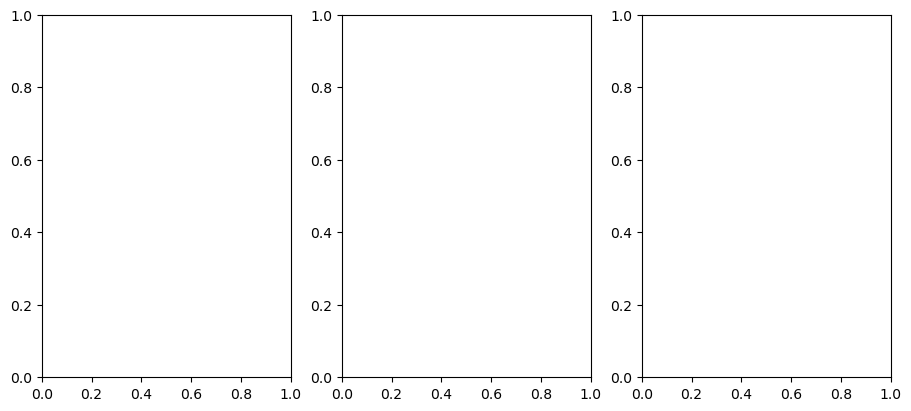

In [218]:
## Initialise panel figure (Figure 3 Main text) ##
fig, axes = plt.subplots(
    1, 3,
    figsize=(9, 4),
    constrained_layout=True
)

## Load data and create main working dataframe

In [220]:
### Open file with f0 data
resFile = DIR + current_file
df = pandas.read_csv(resFile, sep=';')

### Add participant details
detailsFile = DIR + "References_audios_bb.xlsx" # to load BB age etc.
details = pandas.read_excel(detailsFile)
details = details[["BB", "age", "sexe", "Mirror_recognition"]]
df = pandas.merge(df, details, on = ["BB"])

if excl_neutral:
    df = df.loc[~(df["cond"] == "neutre")]
    
df_mum = df.loc[((df["who"] == "M"))] ## KEEPS ONLY the mum
df = df.loc[((df["who"] == "B"))] ## KEEPS ONLY the baby

## recomputes duration to avoid errors
df["duration"] = df["stop_times"] - df["start_times"]
df["BB"] = df["BB"].astype(int) # converts BB number into integer
df_mum["BB"] = df_mum["BB"].astype(int) # converts BB number into integer

df.head()

,index,file,start_times,stop_times,check_timings,duration,phase,who,voc_type,category1_M,category2_M,category1_F,category2_F,agr_cat1,agr_cat2,Garde (0;1),Langue entendue (F;Autre),Langue parlée (1;2),bababa (0;1;2),bodaga (0;1;2),imitation (0;1;2),pointer doigt (0;1),pretend play score (x/7),social gesture score (x/7),words understood (x/139),words spoken (x/139),word spoken all,combiner mots 0;1;2,sentiments (x/4),expressions (x/5),Reco miroir (0;1;2),attire attention soi (0;1;2),aime/aime pas (0;1;2),reco photo (0;1;2),attire attention actions (0;1;2),Unnamed: 34,coded,audio_order,BB,delete_group,merge_group,cond,BBvoc_NM,BBvoc_M,othersound_NM,othersound_M,f0m_NM,f0sd_NM,f0pNa_NM,f0c_NM,f0m_M,f0sd_M,f0pNa_M,f0c_M,f0cSD_NM,f0cSD_M,HNR_M,HNR_NM,RMSm_NM,RMSsd_NM,RMSm_M,RMSsd_M,age,sexe,Mirror_recognition
0,0.0,BB1_6M_1403_p100_NM,38.01,38.79,0.91,0.78,BL,B,B,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_38.01_to_38.79,/BB/BL/BB1_6M_1403_p100_38.01_to_38.79_BL,none,none,583.058213,310.638960,0.146154,523.237621,581.676862,308.015428,0.146154,523.208313,328.124361,328.028831,15.069593,15.139210,399.751780,NaN,390.235571,NaN,6.1,M,NaN
1,1.0,BB1_6M_1403_p100_NM,39.70,40.79,2.89,1.09,BL,B,pB,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_39.7_to_40.79,/BB/BL/BB1_6M_1403_p100_39.7_to_40.79_BL,/other/BL/BB1_6M_1403_p100_NM_38.79_to_39.7,/other/BL/BB1_6M_1403_p100_38.79_to_39.7_BL,626.534615,152.655562,0.821101,523.237621,628.095641,154.142228,0.821101,523.208313,328.124361,328.028831,5.081931,5.965944,154.964475,NaN,139.821527,NaN,6.1,M,NaN
2,2.0,BB1_6M_1403_p100_NM,43.68,45.95,4.05,2.27,BL,B,pB,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_43.68_to_45.95,/BB/BL/BB1_6M_1403_p100_43.68_to_45.95_BL,/other/BL/BB1_6M_1403_p100_NM_40.79_to_43.68,/other/BL/BB1_6M_1403_p100_40.79_to_43.68_BL,701.692272,321.441413,0.662555,523.237621,702.346828,322.889523,0.662555,523.208313,328.124361,328.028831,11.191019,11.929249,209.402410,NaN,190.498479,NaN,6.1,M,NaN
3,3.0,BB1_6M_1403_p100_NM,50.00,50.70,1.14,0.70,BL,B,S,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_50.0_to_50.7,/BB/BL/BB1_6M_1403_p100_50.0_to_50.7_BL,/other/BL/BB1_6M_1403_p100_NM_45.95_to_50.0,/other/BL/BB1_6M_1403_p100_45.95_to_50.0_BL,870.853663,227.406818,0.566524,523.237621,869.763894,226.771471,0.566524,523.208313,328.124361,328.028831,8.744007,9.632715,50.147593,NaN,40.726523,NaN,6.1,M,NaN
4,4.0,BB1_6M_1403_p100_NM,51.84,51.96,1.60,0.12,BL,B,V,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_51.84_to_51.96,/BB/BL/BB1_6M_1403_p100_51.84_to_51.96_BL,/other/BL/BB1_6M_1403_p100_NM_50.7_to_51.84,/other/BL/BB1_6M_1403_p100_50.7_to_51.84_BL,327.876739,12.713441,0.616667,523.237621,326.294348,11.835344,0.616667,523.208313,328.124361,328.028831,4.971112,6.440182,161.880626,NaN,132.862784,NaN,6.1,M,NaN


In [221]:
## Caregiver
df_mum.head()

,index,file,start_times,stop_times,check_timings,duration,phase,who,voc_type,category1_M,category2_M,category1_F,category2_F,agr_cat1,agr_cat2,Garde (0;1),Langue entendue (F;Autre),Langue parlée (1;2),bababa (0;1;2),bodaga (0;1;2),imitation (0;1;2),pointer doigt (0;1),pretend play score (x/7),social gesture score (x/7),words understood (x/139),words spoken (x/139),word spoken all,combiner mots 0;1;2,sentiments (x/4),expressions (x/5),Reco miroir (0;1;2),attire attention soi (0;1;2),aime/aime pas (0;1;2),reco photo (0;1;2),attire attention actions (0;1;2),Unnamed: 34,coded,audio_order,BB,delete_group,merge_group,cond,BBvoc_NM,BBvoc_M,othersound_NM,othersound_M,f0m_NM,f0sd_NM,f0pNa_NM,f0c_NM,f0m_M,f0sd_M,f0pNa_M,f0c_M,f0cSD_NM,f0cSD_M,HNR_M,HNR_NM,RMSm_NM,RMSsd_NM,RMSm_M,RMSsd_M,age,sexe,Mirror_recognition
31,35.0,BB12_6M_1204_m100_NM,13.517,15.368,1.056,1.851,BL,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,12,NaN,NaN,m100,/BB/BL/BB12_6M_1204_m100_NM_13.52_to_15.37,/BB/BL/BB12_6M_1204_m100_13.52_to_15.37_BL,/other/BL/BB12_6M_1204_m100_NM_11.43_to_13.52,/other/BL/BB12_6M_1204_m100_11.43_to_13.52_BL,240.164364,7.721595,0.970270,477.129825,239.167455,5.830967,0.970270,475.556317,220.761915,215.863595,11.454016,10.566269,35.996040,NaN,37.434190,NaN,6.3,F,NaN
32,39.0,BB12_6M_1204_m100_NM,37.341,39.977,2.514,2.636,BL,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,12,NaN,NaN,m100,/BB/BL/BB12_6M_1204_m100_NM_37.34_to_39.98,/BB/BL/BB12_6M_1204_m100_37.34_to_39.98_BL,/other/BL/BB12_6M_1204_m100_NM_36.34_to_37.34,/other/BL/BB12_6M_1204_m100_36.34_to_37.34_BL,412.903524,58.667500,0.687666,477.129825,411.959113,58.732894,0.687666,475.556317,220.761915,215.863595,12.525734,10.868296,30.615578,NaN,30.757404,NaN,6.3,F,NaN
33,40.0,BB12_6M_1204_m100_NM,42.491,43.684,0.635,1.193,BL,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,12,NaN,NaN,m100,/BB/BL/BB12_6M_1204_m100_NM_42.49_to_43.68,/BB/BL/BB12_6M_1204_m100_42.49_to_43.68_BL,/other/BL/BB12_6M_1204_m100_NM_39.98_to_42.49,/other/BL/BB12_6M_1204_m100_39.98_to_42.49_BL,440.121024,12.417532,0.754195,477.129825,439.409283,12.390013,0.754195,475.556317,220.761915,215.863595,17.668500,16.096493,71.824063,NaN,70.353075,NaN,6.3,F,NaN
34,41.0,BB12_6M_1204_m100_NM,44.319,44.522,0.735,0.203,BL,M,NaN,M,NaN,N,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11.0,12,NaN,NaN,m100,/BB/BL/BB12_6M_1204_m100_NM_44.32_to_44.52,/BB/BL/BB12_6M_1204_m100_44.32_to_44.52_BL,/other/BL/BB12_6M_1204_m100_NM_43.68_to_44.32,/other/BL/BB12_6M_1204_m100_43.68_to_44.32_BL,NaN,NaN,1.000000,477.129825,NaN,NaN,1.000000,475.556317,220.761915,215.863595,9.047196,11.503876,70.632221,NaN,60.049978,NaN,6.3,F,NaN
35,42.0,BB12_6M_1204_m100_NM,45.257,46.534,3.958,1.277,BL,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,12,NaN,NaN,m100,/BB/BL/BB12_6M_1204_m100_NM_45.26_to_46.53,/BB/BL/BB12_6M_1204_m100_45.26_to_46.53_BL,/other/BL/BB12_6M_1204_m100_NM_44.52_to_45.26,/other/BL/BB12_6M_1204_m100_44.52_to_45.26_BL,858.665685,205.390851,0.731402,477.129825,854.160146,201.914739,0.731402,475.556317,220.761915,215.863595,7.771228,8.711776,59.258054,NaN,57.245237,NaN,6.3,F,NaN


In [222]:
## PARTICIPANT DETAILS
nsuj = len(np.unique(df["BB"]))

## any differences in age between groups?
age_m = df.groupby(["cond","BB"])["age"].mean().reset_index()
print("nb BB?", nsuj)
print("nb 6mo?", len(age_m.loc[age_m["age"] >= 5.5]), np.mean(age_m.loc[age_m["age"] >= 5.5, "age"]), np.std(age_m.loc[age_m["age"] >= 5.5, "age"]))
print("nb 3mo?", len(age_m.loc[age_m["age"] < 5.5]), np.mean(age_m.loc[age_m["age"] < 5.5, "age"]), np.std(age_m.loc[age_m["age"] < 5.5, "age"]))

m100_age = age_m.loc[age_m["cond"] == "m100", "age"]
print("m100_age", np.mean(m100_age), np.std(m100_age), len(m100_age))
p100_age = age_m.loc[age_m["cond"] == "p100", "age"]
print("p100_age", np.mean(p100_age), np.std(p100_age), len(p100_age))
neutre_age = age_m.loc[age_m["cond"] == "neutre", "age"]
print("neutre", np.mean(neutre_age), np.std(neutre_age), len(neutre_age))
print(stats.ttest_ind(m100_age, p100_age)) # , nan_policy="omit"

nb BB? 72
nb 6mo? 36 6.269444444453703 0.24157086222830432
nb 3mo? 36 3.7787037037129627 0.20520281712746383
m100_age 5.0680000000000005 1.2768182677612696 25
p100_age 4.995652173927536 1.2667926843274113 23
neutre 5.005555555569445 1.2507281829733414 24
TtestResult(statistic=0.19270887321834054, pvalue=0.8480352772504051, df=46.0)


In [223]:
# Min and max age per condition:
print("age", np.min(m100_age), np.max(m100_age), len(m100_age))
#print("age", np.min(p100_age), np.max(p100_age), len(p100_age))
#print("age", np.min(neutre_age), np.max(neutre_age), len(neutre_age))

age 3.466666666666667 7.166666666666667 25


In [224]:
# Age all data mean and std:
print("age all", np.mean(age_m["age"]), np.std(age_m["age"]))

age all 5.024074074083334 1.2653772948072919


In [225]:
## Retrive vocalisation type:
df["Type_protophone"] = df["voc_type"].astype(str)
df["Type_voc"] = "Reflexive sound"
df.loc[np.isin(df["Type_protophone"], ['B', 'Gr', 'S', 'V', 'pB']), "Type_voc"] = "Protophone"
df["is_babbling"] = 0
df.loc[np.isin(df["Type_protophone"], ['B']), "is_babbling"] = 1
df["is_margbabbling"] = 0
df.loc[np.isin(df["Type_protophone"], ['B', 'V', 'pB']), "is_margbabbling"] = 1
sujlist = np.unique(df["BB"])
print(sujlist, len(sujlist))

[  1  12  15  18  21  23  24  27  31  36  38  45  47  52  56  58  61  66
  68  69  70  71  72  74  77  78  81  88  90  91  92  94  96  99 100 101
 103 104 109 110 111 112 114 115 116 117 118 119 120 121 122 123 125 127
 129 130 131 133 134 141 142 143 144 148 149 150 155 156 159 160 161 163] 72


In [226]:
# How many mums do we have data from:
sujlist_mum = np.unique(df_mum["BB"])
print(sujlist_mum, len(sujlist_mum))

[ 12  15  18  21  23  24  27  31  36  38  45  47  52  56  61  66  68  69
  70  71  72  74  77  78  81  88  90  91  92 101 103 104 109 110 111 114
 115 116 117 118 119 120 121 122 123 125 127 129 130 131 133 134 141 142
 143 144 148 149 150 155 156 159 160 161 163] 65


In [227]:
# How many mums without vocalisations:
(np.setdiff1d(sujlist, sujlist_mum))

array([  1,  58,  94,  96,  99, 100, 112])

## Pre-processing

In [229]:
## TO EXCLUDE Vegetative sounds & fussing sounds & whispers & covocalisations & raspberries
if excl_notvoc:
    df = df.loc[df["Type_protophone"] != "VS"]
    df = df.loc[df["Type_protophone"] != "F"]
    df = df.loc[df["Type_protophone"] != "W"]
    df = df.loc[df["Type_protophone"] != "R"]
    df = df.loc[df["Type_protophone"] != "CoV"]
#    df = df.loc[df["Type_protophone"] != "L"]

if excl_reflexive:
    df = df.loc[df["Type_voc"] == 'Protophone']

### COUNTS VOCALIZATIONS /BB /phase
for s in np.unique(df["BB"]):
    for p in ['BL', 'EXP']:
        cur = df.loc[((df["BB"] == s) & (df["phase"] == p))].sort_values("start_times")
        cur["voc_nb"] = np.arange(len(cur))+1
        df.loc[((df["BB"] == s) & (df["phase"] == p)), "voc_nb"] = np.array(cur["voc_nb"])
        
    ## OVERALL (not per phase)
    cur = df.loc[((df["BB"] == s))].sort_values("start_times")
    cur["voc_nb_all"] = np.arange(len(cur))+1
    df.loc[((df["BB"] == s)), "voc_nb_all"] = np.array(cur["voc_nb_all"])

## COUNTS NB OF VOCS    
count_vocs = df.groupby(["BB",'age'])["voc_nb_all"].max().reset_index(name="total_nb_voc")
df = pandas.merge(df, count_vocs, on = ["BB", "age"])

sujlist = np.unique(df["BB"])
print(sujlist, len(sujlist))

## COMPUTES THE %protophones per infant
count_protophones = df.groupby(["Type_voc", "BB"])["age"].count().reset_index(name="nb_protophones").sort_values("BB")
count_protophones = count_protophones.loc[count_protophones["Type_voc"] == "Protophone"]
df = pandas.merge(df, count_protophones[["nb_protophones", "BB"]], on = "BB")

### AND THE % of sounds that are either B/V or pB
margbabbling_m = df.groupby(["BB"])["is_margbabbling"].mean().reset_index(name="p_margbabbling")
df = pandas.merge(df, margbabbling_m[["p_margbabbling", "BB"]], on = "BB")

### AND THE % of sounds that are proper B
babbling_m = df.groupby(["BB"])["is_babbling"].mean().reset_index(name="p_babbling")
df = pandas.merge(df, babbling_m[["p_babbling", "BB"]], on = "BB")

### TO USE ONLY 10 vocs in BL and 10 vocs in EXP
if keep_10:
    df_m = df.groupby(["BB", "phase"])["voc_nb"].max().reset_index(name="total_voc_nb")
    df = pandas.merge(df,df_m, on =["BB", "phase"])
    df["count_voc_BL"] = df["voc_nb"] - df["total_voc_nb"]
    df = df.loc[(((df["voc_nb"] <= nkeep) & (df["phase"] == "EXP")) | ((df["count_voc_BL"] >= (-nkeep+1)) & (df["phase"] == "BL")))]
    df = df.loc[(((df["voc_nb"] <= 10) & (df["phase"] == "EXP")) | ((df["phase"] == "BL")))] # OR JUST FOR EXP
        
## RENAME A FEW COLUMNS SO WE UNDERSTAND WHAT THEY ARE A BIT MORE EASILY
df["age_c"] = 6
df.loc[df["age"] < 5, "age_c"] = 4

print(np.array(list(df))) ## TO LIST THE COLUMN NAMES
df.head(4)

[  1  12  15  18  21  23  24  27  31  36  38  45  47  52  56  58  61  66
  68  69  70  71  72  74  77  78  81  88  90  91  92  94  96  99 100 101
 103 104 109 110 111 112 114 115 116 117 118 119 120 121 122 123 125 127
 129 130 131 133 134 141 142 143 144 148 149 150 155 156 159 160 161 163] 72
['index' 'file' 'start_times' 'stop_times' 'check_timings' 'duration'
 'phase' 'who' 'voc_type' 'category1_M' 'category2_M' 'category1_F'
 'category2_F' 'agr_cat1' 'agr_cat2' 'Garde (0;1)'
 'Langue entendue (F;Autre)' 'Langue parlée (1;2)' 'bababa (0;1;2)'
 'bodaga (0;1;2)' 'imitation (0;1;2)' 'pointer doigt (0;1)'
 'pretend play score (x/7)' 'social gesture score (x/7)'
 'words understood (x/139)' 'words spoken (x/139)' 'word spoken all'
 'combiner mots 0;1;2' 'sentiments (x/4)' 'expressions (x/5)'
 'Reco miroir (0;1;2)' 'attire attention soi (0;1;2)'
 'aime/aime pas (0;1;2)' 'reco photo (0;1;2)'
 'attire attention actions (0;1;2)' 'Unnamed: 34' 'coded' 'audio_order'
 'BB' 'delete_group' 'merge

,index,file,start_times,stop_times,check_timings,duration,phase,who,voc_type,category1_M,category2_M,category1_F,category2_F,agr_cat1,agr_cat2,Garde (0;1),Langue entendue (F;Autre),Langue parlée (1;2),bababa (0;1;2),bodaga (0;1;2),imitation (0;1;2),pointer doigt (0;1),pretend play score (x/7),social gesture score (x/7),words understood (x/139),words spoken (x/139),word spoken all,combiner mots 0;1;2,sentiments (x/4),expressions (x/5),Reco miroir (0;1;2),attire attention soi (0;1;2),aime/aime pas (0;1;2),reco photo (0;1;2),attire attention actions (0;1;2),Unnamed: 34,coded,audio_order,BB,delete_group,merge_group,cond,BBvoc_NM,BBvoc_M,othersound_NM,othersound_M,f0m_NM,f0sd_NM,f0pNa_NM,f0c_NM,f0m_M,f0sd_M,f0pNa_M,f0c_M,f0cSD_NM,f0cSD_M,HNR_M,HNR_NM,RMSm_NM,RMSsd_NM,RMSm_M,RMSsd_M,age,sexe,Mirror_recognition,Type_protophone,Type_voc,is_babbling,is_margbabbling,voc_nb,voc_nb_all,total_nb_voc,nb_protophones,p_margbabbling,p_babbling,age_c
0,0.0,BB1_6M_1403_p100_NM,38.01,38.79,0.91,0.78,BL,B,B,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_38.01_to_38.79,/BB/BL/BB1_6M_1403_p100_38.01_to_38.79_BL,none,none,583.058213,310.638960,0.146154,523.237621,581.676862,308.015428,0.146154,523.208313,328.124361,328.028831,15.069593,15.139210,399.751780,NaN,390.235571,NaN,6.1,M,NaN,B,Protophone,1,1,1.0,1.0,30.0,29,0.733333,0.033333,6
1,1.0,BB1_6M_1403_p100_NM,39.70,40.79,2.89,1.09,BL,B,pB,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_39.7_to_40.79,/BB/BL/BB1_6M_1403_p100_39.7_to_40.79_BL,/other/BL/BB1_6M_1403_p100_NM_38.79_to_39.7,/other/BL/BB1_6M_1403_p100_38.79_to_39.7_BL,626.534615,152.655562,0.821101,523.237621,628.095641,154.142228,0.821101,523.208313,328.124361,328.028831,5.081931,5.965944,154.964475,NaN,139.821527,NaN,6.1,M,NaN,pB,Protophone,0,1,2.0,2.0,30.0,29,0.733333,0.033333,6
2,2.0,BB1_6M_1403_p100_NM,43.68,45.95,4.05,2.27,BL,B,pB,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_43.68_to_45.95,/BB/BL/BB1_6M_1403_p100_43.68_to_45.95_BL,/other/BL/BB1_6M_1403_p100_NM_40.79_to_43.68,/other/BL/BB1_6M_1403_p100_40.79_to_43.68_BL,701.692272,321.441413,0.662555,523.237621,702.346828,322.889523,0.662555,523.208313,328.124361,328.028831,11.191019,11.929249,209.402410,NaN,190.498479,NaN,6.1,M,NaN,pB,Protophone,0,1,3.0,3.0,30.0,29,0.733333,0.033333,6
3,3.0,BB1_6M_1403_p100_NM,50.00,50.70,1.14,0.70,BL,B,S,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_50.0_to_50.7,/BB/BL/BB1_6M_1403_p100_50.0_to_50.7_BL,/other/BL/BB1_6M_1403_p100_NM_45.95_to_50.0,/other/BL/BB1_6M_1403_p100_45.95_to_50.0_BL,870.853663,227.406818,0.566524,523.237621,869.763894,226.771471,0.566524,523.208313,328.124361,328.028831,8.744007,9.632715,50.147593,NaN,40.726523,NaN,6.1,M,NaN,S,Protophone,0,0,4.0,4.0,30.0,29,0.733333,0.033333,6


In [230]:
### CHECKS THAT THE SPELLING IS RIGHT FOR THE TYPES OF SOUNDS and if not unifies all names + merges some categ
print(np.unique(df["Type_voc"]))
print(np.unique(df["Type_protophone"]))
#print(np.unique(exp["Type_protophone"]))

['Protophone' 'Reflexive sound']
['B' 'Cr' 'Gr' 'L' 'S' 'UnS' 'V' 'nan' 'pB']


In [231]:
### PERMUTE CONDITIONS FOR CONTROL ANALYSIS (for Supplementary Anaysis 3)

# Get unique pairs of bb-cond
participants = df[['file', 'cond']].drop_duplicates()
conditions = ['m100', 'p100']

#PERMUTE:
np.random.seed(1)  # for reproducibility
participants['perm_cond'] = np.random.choice(conditions, size=len(participants))

# drop the 'cond'
participants = participants[['file', 'perm_cond']]

# merge with df
df = df.merge(participants, on='file', how='left')

In [232]:
### CONVERTS F0 TO MELs (recommended) or CEN

# FROM Praat (Boersma & Weenink 2019) uses the formula: mel = 550 * ln(1+f/550)
if if_convert_f0_mel: #RECOMMENDED
    for u in ["f0m_NM", "f0m_M"]:
        df[u] = 550 * np.log(1+df[u]/550)
        df_mum[u] = 550 * np.log(1+df_mum[u]/550)
    difference_legend = "output - input (mel)"
elif if_convert_f0_cent: #NOT RECOMMENDED
    difference_legend = "output - input (cent)"
    df["f0m_NM"] = 1200 * np.log2(df["f0m_NM"] / 440)
#    df["f0m_M"] = 1200 * np.log2(df["f0m_M"] / 440)
    df["f0m_M"] = 1200 * np.log2(df["f0m_M"] / df["f0m_NM"])
else:
    difference_legend = "output - input (Hz)"
df["M_minus_NM"] = df["f0m_M"] - df["f0m_NM"] # 4 BB
df_mum["M_minus_NM"] = df_mum["f0m_M"] - df_mum["f0m_NM"] # F M

In [233]:
### CREATES SEPARATE DF FOR EXP AND BASELINE phases
baseline = df.loc[df["phase"] == "BL"]  # selectionne juste la baseline

### COMPUTES MEAN F0 FOR EACH phase & EACH BB for NM and M files for infant voc
baseline_m = baseline.groupby(["BB", "cond", "perm_cond"])[["f0m_NM", "f0m_M","HNR_NM", "HNR_M","RMSm_NM", "RMSm_M"]].mean().reset_index()
baseline_m = baseline_m.rename(columns={"f0m_NM": "baseline_mean_f0_NM", "f0m_M": "baseline_mean_f0_M",
                                       "HNR_NM": "baseline_mean_HNR_NM", "HNR_M": "baseline_mean_HNR_M",
                                       "RMSm_NM": "baseline_mean_RMSm_NM", "RMSm_M": "baseline_mean_RMSm_M"})
df = pandas.merge(df, baseline_m, on = ["BB", "cond", "perm_cond"])

### COMPUTES STD F0 FOR EACH phase & EACH BB for NM and M files for infant voc
baseline_sd = baseline.groupby(["BB", "cond", "perm_cond"])[["f0m_NM", "f0m_M","HNR_NM", "HNR_M","RMSm_NM", "RMSm_M"]].std().reset_index()
baseline_sd = baseline_sd.rename(columns={"f0m_NM": "baseline_std_f0_NM", "f0m_M": "baseline_std_f0_M",
                                       "HNR_NM": "baseline_std_HNR_NM", "HNR_M": "baseline_std_HNR_M",
                                       "RMSm_NM": "baseline_std_RMSm_NM", "RMSm_M": "baseline_std_RMSm_M"})
df = pandas.merge(df, baseline_sd, on = ["BB", "cond", "perm_cond"])
    
## COMPUTES Z-SCORE / BASELINE for each vocalisation in the NM files for BB vocs
## zf0 = (f0 - f0_meanB_baseline) / f0_sdB_baseline
df["zf0_Original"] = (df["f0m_NM"] - df["baseline_mean_f0_NM"]) / df["baseline_std_f0_NM"]
df["zf0_Original_inv"] = df["zf0_Original"]
df.loc[df["cond"] == "p100", "zf0_Original_inv"] = -df.loc[df["cond"] == "p100", "zf0_Original_inv"]
df.loc[df["cond"] == "neutre", "zf0_Original_inv"] = np.nan
df["zf0_Original_abs"] = abs(df["zf0_Original"]) # magnitude du changement entre EXP ET BASELINE
df["difference_inv"] = df["M_minus_NM"] # magnitude du changement entre EXP ET BASELINE
df.loc[df["cond"] == "p100", "difference_inv"] = -df.loc[df["cond"] == "p100", "difference_inv"]
df.loc[df["cond"] == "neutre", "difference_inv"] = np.nan

## COMPUTES Z-SCORE / BASELINE for HNR & RMS
df["zHNR_Original"] = (df["HNR_NM"] - df["baseline_mean_HNR_NM"]) / df["baseline_std_HNR_NM"]
df["zRMS_Original"] = (df["RMSm_NM"] - df["baseline_mean_RMSm_NM"]) / df["baseline_std_RMSm_NM"]

## computes z_score for concatenated data - f0cSD_M & f0c_NM
dfc = df.groupby(["BB", "cond", "perm_cond", "phase","age"])[["f0c_NM", "f0c_M", "f0cSD_NM", "f0cSD_M"]].mean().reset_index()
dfc["M_minus_NM"] = dfc["f0c_M"] - dfc["f0c_NM"]
dfc_baseline = dfc.loc[dfc["phase"] == "BL"].reset_index()  # selectionne juste la baseline
dfc_exp = dfc.loc[dfc["phase"] == "EXP"].reset_index()  # selectionne juste la phase exp
dfc_exp["zf0c_Original"] = (dfc_exp["f0c_NM"] - dfc_baseline["f0c_NM"]) / dfc_baseline["f0cSD_NM"]
dfc_exp["zf0c_Original_inv"] = dfc_exp["zf0c_Original"]
dfc_exp.loc[dfc_exp["cond"] == "p100", "zf0c_Original_inv"] = -dfc_exp.loc[dfc_exp["cond"] == "p100", "zf0c_Original_inv"]
dfc_exp.loc[dfc_exp["cond"] == "neutre", "zf0c_Original_inv"] = np.nan

## SEPARATES PHASES
exp = df.loc[df["phase"] == "EXP"]  # selectionne juste la phase expérimentale
count_vocs_exp = exp.groupby(["BB",'age'])["voc_nb"].max().reset_index(name="exp_nb_voc")
exp = pandas.merge(exp, count_vocs_exp, on = ["BB", "age"])

bl = df.loc[df["phase"] == "BL"]  # selectionne juste la phase expérimentale
count_vocs_bl = bl.groupby(["BB",'age'])["voc_nb"].max().reset_index(name="bl_nb_voc")
exp = pandas.merge(exp, count_vocs_bl, on = ["BB", "age"])

df.head(10)

,index,file,start_times,stop_times,check_timings,duration,phase,who,voc_type,category1_M,category2_M,category1_F,category2_F,agr_cat1,agr_cat2,Garde (0;1),Langue entendue (F;Autre),Langue parlée (1;2),bababa (0;1;2),bodaga (0;1;2),imitation (0;1;2),pointer doigt (0;1),pretend play score (x/7),social gesture score (x/7),words understood (x/139),words spoken (x/139),word spoken all,combiner mots 0;1;2,sentiments (x/4),expressions (x/5),Reco miroir (0;1;2),attire attention soi (0;1;2),aime/aime pas (0;1;2),reco photo (0;1;2),attire attention actions (0;1;2),Unnamed: 34,coded,audio_order,BB,delete_group,merge_group,cond,BBvoc_NM,BBvoc_M,othersound_NM,othersound_M,f0m_NM,f0sd_NM,f0pNa_NM,f0c_NM,f0m_M,f0sd_M,f0pNa_M,f0c_M,f0cSD_NM,f0cSD_M,HNR_M,HNR_NM,RMSm_NM,RMSsd_NM,RMSm_M,RMSsd_M,age,sexe,Mirror_recognition,Type_protophone,Type_voc,is_babbling,is_margbabbling,voc_nb,voc_nb_all,total_nb_voc,nb_protophones,p_margbabbling,p_babbling,age_c,perm_cond,M_minus_NM,baseline_mean_f0_NM,baseline_mean_f0_M,baseline_mean_HNR_NM,baseline_mean_HNR_M,baseline_mean_RMSm_NM,baseline_mean_RMSm_M,baseline_std_f0_NM,baseline_std_f0_M,baseline_std_HNR_NM,baseline_std_HNR_M,baseline_std_RMSm_NM,baseline_std_RMSm_M,zf0_Original,zf0_Original_inv,zf0_Original_abs,difference_inv,zHNR_Original,zRMS_Original
0,0.0,BB1_6M_1403_p100_NM,38.01,38.79,0.91,0.78,BL,B,B,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_38.01_to_38.79,/BB/BL/BB1_6M_1403_p100_38.01_to_38.79_BL,none,none,397.516549,310.638960,0.146154,523.237621,396.845615,308.015428,0.146154,523.208313,328.124361,328.028831,15.069593,15.139210,399.751780,NaN,390.235571,NaN,6.1,M,NaN,B,Protophone,1,1,1.0,1.0,30.0,29,0.733333,0.033333,6,p100,-0.670934,403.748376,404.39553,10.638562,10.34564,218.951191,191.515574,115.871357,117.555896,4.729223,4.899935,141.164031,116.551884,-0.053782,0.053782,0.053782,0.670934,0.951668,1.280784
1,1.0,BB1_6M_1403_p100_NM,39.70,40.79,2.89,1.09,BL,B,pB,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_39.7_to_40.79,/BB/BL/BB1_6M_1403_p100_39.7_to_40.79_BL,/other/BL/BB1_6M_1403_p100_NM_38.79_to_39.7,/other/BL/BB1_6M_1403_p100_38.79_to_39.7_BL,418.225694,152.655562,0.821101,523.237621,418.954950,154.142228,0.821101,523.208313,328.124361,328.028831,5.081931,5.965944,154.964475,NaN,139.821527,NaN,6.1,M,NaN,pB,Protophone,0,1,2.0,2.0,30.0,29,0.733333,0.033333,6,p100,0.729256,403.748376,404.39553,10.638562,10.34564,218.951191,191.515574,115.871357,117.555896,4.729223,4.899935,141.164031,116.551884,0.124943,-0.124943,0.124943,-0.729256,-0.988031,-0.453279
2,2.0,BB1_6M_1403_p100_NM,43.68,45.95,4.05,2.27,BL,B,pB,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_43.68_to_45.95,/BB/BL/BB1_6M_1403_p100_43.68_to_45.95_BL,/other/BL/BB1_6M_1403_p100_NM_40.79_to_43.68,/other/BL/BB1_6M_1403_p100_40.79_to_43.68_BL,452.283400,321.441413,0.662555,523.237621,452.570940,322.889523,0.662555,523.208313,328.124361,328.028831,11.191019,11.929249,209.402410,NaN,190.498479,NaN,6.1,M,NaN,pB,Protophone,0,1,3.0,3.0,30.0,29,0.733333,0.033333,6,p100,0.287540,403.748376,404.39553,10.638562,10.34564,218.951191,191.515574,115.871357,117.555896,4.729223,4.899935,141.164031,116.551884,0.418870,-0.418870,0.418870,-0.287540,0.272917,-0.067643
3,3.0,BB1_6M_1403_p100_NM,50.00,50.70,1.14,0.70,BL,B,S,NaN,NaN,NaN,NaN,1.0,1.0,1.0,F,1.0,2.0,2.0,2.0,1.0,4.0,5.0,86.0,10.0,10.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,p100,/BB/BL/BB1_6M_1403_p100_NM_50.0_to_50.7,/BB/BL/BB1_6M_1403_p100_50.0_to_50.7_BL,/other/BL/BB1_6M_1403_p100_NM_45.95_to_50.0,/other/BL/BB1_6M_1403_p100_45.95_to_50.0_BL,522.002175,227.406818,0.566524,523.237621,521.580173,226.771471,0.566524,523.208313,328.124361,328.02883

In [234]:
### SAME FOR THE MUM
baseline_mum = df_mum.loc[df_mum["phase"] == "BL"]  # selectionne juste la baseline_mum

### COMPUTES MEAN F0 FOR EACH phase & EACH BB for NM and M files for infant voc
baseline_mum_m = baseline_mum.groupby(["BB", "cond"])[["f0m_NM", "f0m_M","HNR_NM", "HNR_M","RMSm_NM", "RMSm_M"]].mean().reset_index()
baseline_mum_m = baseline_mum_m.rename(columns={"f0m_NM": "baseline_mum_mean_f0_NM", "f0m_M": "baseline_mum_mean_f0_M",
                                       "HNR_NM": "baseline_mum_mean_HNR_NM", "HNR_M": "baseline_mum_mean_HNR_M",
                                       "RMSm_NM": "baseline_mum_mean_RMSm_NM", "RMSm_M": "baseline_mum_mean_RMSm_M"})
df_mum = pandas.merge(df_mum, baseline_mum_m, on = ["BB", "cond"])

### COMPUTES STD F0 FOR EACH phase & EACH BB for NM and M files for infant voc
baseline_mum_sd = baseline_mum.groupby(["BB", "cond"])[["f0m_NM", "f0m_M","HNR_NM", "HNR_M","RMSm_NM", "RMSm_M"]].std().reset_index()
baseline_mum_sd = baseline_mum_sd.rename(columns={"f0m_NM": "baseline_mum_std_f0_NM", "f0m_M": "baseline_mum_std_f0_M",
                                       "HNR_NM": "baseline_mum_std_HNR_NM", "HNR_M": "baseline_mum_std_HNR_M",
                                       "RMSm_NM": "baseline_mum_std_RMSm_NM", "RMSm_M": "baseline_mum_std_RMSm_M"})
df_mum = pandas.merge(df_mum, baseline_mum_sd, on = ["BB", "cond"])
    
## COMPUTES Z-SCORE / baseline_mum for each vocalisation in the NM files for BB vocs
## zf0 = (f0 - f0_meanB_baseline_mum) / f0_sdB_baseline_mum
df_mum["zf0_Original"] = (df_mum["f0m_NM"] - df_mum["baseline_mum_mean_f0_NM"]) / df_mum["baseline_mum_std_f0_NM"]
df_mum["zf0_Original_inv"] = df_mum["zf0_Original"]
df_mum.loc[df_mum["cond"] == "p100", "zf0_Original_inv"] = -df_mum.loc[df_mum["cond"] == "p100", "zf0_Original_inv"]
df_mum.loc[df_mum["cond"] == "neutre", "zf0_Original_inv"] = np.nan

## computes z_score for concatenated data - f0cSD_M & f0c_NM
dfc_mum = df_mum.groupby(["BB", "cond", "phase","age"])[["f0c_NM", "f0c_M", "f0cSD_NM", "f0cSD_M"]].mean().reset_index()
dfc_mum["M_minus_NM"] = dfc_mum["f0c_M"] - dfc_mum["f0c_NM"]
dfc_mum_baseline = dfc_mum.loc[dfc_mum["phase"] == "BL"].reset_index()  # selectionne juste la baseline
dfc_mum_exp = dfc_mum.loc[dfc_mum["phase"] == "EXP"].reset_index()  # selectionne juste la phase exp
dfc_mum_exp["zf0c_Original"] = (dfc_mum_exp["f0c_NM"] - dfc_mum_baseline["f0c_NM"]) / dfc_mum_baseline["f0cSD_NM"]
dfc_mum_exp["zf0c_Original_inv"] = dfc_mum_exp["zf0c_Original"]
dfc_mum_exp.loc[dfc_mum_exp["cond"] == "p100", "zf0c_Original_inv"] = -dfc_mum_exp.loc[dfc_mum_exp["cond"] == "p100", "zf0c_Original_inv"]
dfc_mum_exp.loc[dfc_mum_exp["cond"] == "neutre", "zf0c_Original_inv"] = np.nan

## SEPARATES PHASES
exp_mum = df_mum.loc[df_mum["phase"] == "EXP"]  # selectionne juste la phase expérimentale
exp_mum.head(10)

,index,file,start_times,stop_times,check_timings,duration,phase,who,voc_type,category1_M,category2_M,category1_F,category2_F,agr_cat1,agr_cat2,Garde (0;1),Langue entendue (F;Autre),Langue parlée (1;2),bababa (0;1;2),bodaga (0;1;2),imitation (0;1;2),pointer doigt (0;1),pretend play score (x/7),social gesture score (x/7),words understood (x/139),words spoken (x/139),word spoken all,combiner mots 0;1;2,sentiments (x/4),expressions (x/5),Reco miroir (0;1;2),attire attention soi (0;1;2),aime/aime pas (0;1;2),reco photo (0;1;2),attire attention actions (0;1;2),Unnamed: 34,coded,audio_order,BB,delete_group,merge_group,cond,BBvoc_NM,BBvoc_M,othersound_NM,othersound_M,f0m_NM,f0sd_NM,f0pNa_NM,f0c_NM,f0m_M,f0sd_M,f0pNa_M,f0c_M,f0cSD_NM,f0cSD_M,HNR_M,HNR_NM,RMSm_NM,RMSsd_NM,RMSm_M,RMSsd_M,age,sexe,Mirror_recognition,M_minus_NM,baseline_mum_mean_f0_NM,baseline_mum_mean_f0_M,baseline_mum_mean_HNR_NM,baseline_mum_mean_HNR_M,baseline_mum_mean_RMSm_NM,baseline_mum_mean_RMSm_M,baseline_mum_std_f0_NM,baseline_mum_std_f0_M,baseline_mum_std_HNR_NM,baseline_mum_std_HNR_M,baseline_mum_std_RMSm_NM,baseline_mum_std_RMSm_M,zf0_Original,zf0_Original_inv
17,70.0,BB12_6M_1204_m100_NM,187.196,188.737,0.774,1.541,EXP,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,42.0,12,NaN,NaN,m100,/BB/EXP/BB12_6M_1204_m100_NM_187.2_to_188.74,/BB/EXP/BB12_6M_1204_m100_187.2_to_188.74_EXP,/other/EXP/BB12_6M_1204_m100_NM_184.73_to_187.2,/other/EXP/BB12_6M_1204_m100_184.73_to_187.2_EXP,660.549203,162.806298,0.971429,412.042615,635.093618,148.484264,0.971429,385.139504,343.483254,341.715390,6.544060,6.842694,25.059806,NaN,25.247360,NaN,6.300000,F,NaN,-25.455585,365.384609,364.180355,10.849422,11.187065,45.630182,42.819563,102.402579,101.723139,4.172083,4.823156,21.630075,21.660565,2.882394,2.882394
18,71.0,BB12_6M_1204_m100_NM,189.511,189.663,0.897,0.152,EXP,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,43.0,12,NaN,NaN,m100,/BB/EXP/BB12_6M_1204_m100_NM_189.51_to_189.66,/BB/EXP/BB12_6M_1204_m100_189.51_to_189.66_EXP,/other/EXP/BB12_6M_1204_m100_NM_188.74_to_189.51,/other/EXP/BB12_6M_1204_m100_188.74_to_189.51_EXP,NaN,NaN,1.000000,412.042615,NaN,NaN,1.000000,385.139504,343.483254,341.715390,7.765649,6.382046,51.695231,NaN,55.085316,NaN,6.300000,F,NaN,NaN,365.384609,364.180355,10.849422,11.187065,45.630182,42.819563,102.402579,101.723139,4.172083,4.823156,21.630075,21.660565,NaN,NaN
19,76.0,BB12_6M_1204_m100_NM,203.511,204.572,0.706,1.061,EXP,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47.0,12,NaN,NaN,m100,/BB/EXP/BB12_6M_1204_m100_NM_203.51_to_204.57,/BB/EXP/BB12_6M_1204_m100_203.51_to_204.57_EXP,/other/EXP/BB12_6M_1204_m100_NM_199.4_to_203.51,/other/EXP/BB12_6M_1204_m100_199.4_to_203.51_EXP,216.678887,20.190019,0.671698,412.042615,199.817248,15.311827,0.671698,385.139504,343.483254,341.715390,7.054356,7.621463,34.467457,NaN,29.756894,NaN,6.300000,F,NaN,-16.861639,365.384609,364.180355,10.849422,11.187065,45.630182,42.819563,102.402579,101.723139,4.172083,4.823156,21.630075,21.660565,-1.452168,-1.452168
20,77.0,BB12_6M_1204_m100_NM,205.278,207.835,4.895,2.557,EXP,M,NaN,M,NaN,M,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,48.0,12,NaN,NaN,m100,/BB/EXP/BB12_6M_1204_m100_NM_205.28_to_207.84,/BB/EXP/BB12_6M_1204_m100_205.28_to_207.84_EXP,/other/EXP/BB12_6M_1204_m100_NM_204.57_to_205.28,/other/EXP/BB12_6M_1204_m100_204.57_to_205.28_EXP,280.781772,295.124012,0.960110,412.042615,270.351372,320.743836,0.960110,385.139504,343.483254,341.715390,9.243938,9.591803,157.148984,NaN,169.136334,NaN,6.300000,F,NaN,-10.430400,365.384609,364.180355,10.849422,11.187065,45.630182,42.819563,102.402579,101.723139,4.172083,4.823156,21.630075,21.660565,-0.826179,-0.826179
21,78.0,BB12_6M_1204_m100_NM,212.730,213.125,0.386,0.395,EXP,M,NaN,M,NaN,M,NaN

In [235]:
# Check: how many participants
sujlist = np.unique(df["BB"])
print(sujlist, len(sujlist))

[  1  12  15  18  21  23  24  27  31  36  38  45  47  52  56  58  61  66
  68  69  70  71  72  74  77  78  81  88  90  91  92  94  96  99 100 101
 103 104 109 110 111 112 114 115 116 117 118 119 120 121 122 123 125 127
 129 130 131 133 134 141 142 143 144 148 149 150 155 156 159 160 161 163] 72


In [236]:
# Get the average transformation size (infant)
exp_m = exp.groupby(["BB","cond"])[["M_minus_NM", "f0m_M"]].mean().reset_index() 

In [237]:
# Get the average transformation size (adult, for control analysis)
exp_mum_m = exp_mum.groupby(["BB","cond"])[["M_minus_NM"]].mean().reset_index()

## Check that pitch transformation was successfuly applied (Supplementary analysis 1)

In [239]:
# MEAN and STD f0 in baseline (all cond)
print("BL", np.mean(baseline["M_minus_NM"]), np.std(baseline["M_minus_NM"]))

BL -0.39742515762013997 4.357003378583089


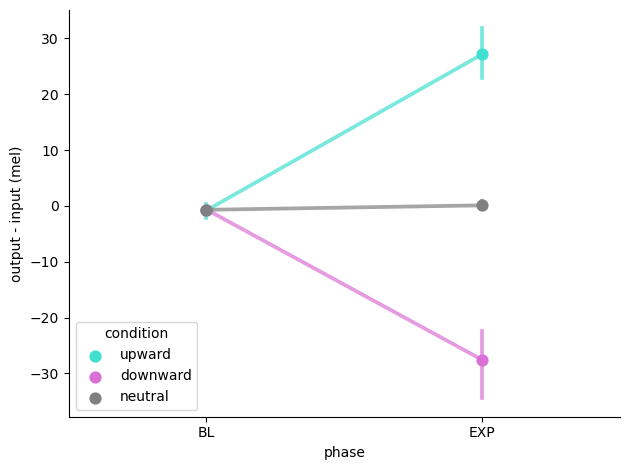

In [240]:
## FIGURE S1: Pitch tranformation
ax = sns.pointplot(x="phase", y="M_minus_NM", data = dfc, hue = "cond", palette = condColor, units = "BB")
for line in ax.lines:
    line.set_alpha(0.7)
sns.despine()
plt.ylabel(difference_legend)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["upward", "downward", "neutral"], frameon=True, loc="lower left", fontsize=10, title = "condition")

# Enregistrer le graphique dans un fichier (png high quality, pdf)
filename = f"FIGURE_S1_transformation_check.png"
filepath = os.path.join(output_dir, filename)
plt.tight_layout(pad=0.3)
plt.savefig(filepath, dpi=300, bbox_inches="tight")

filename_pdf = f"FIGURE_S1_transformation_check.pdf"
filepath_pdf = os.path.join(output_dir, filename_pdf)
plt.tight_layout()
plt.savefig(filepath_pdf)

## Vocalisation type and number (Supplementary Analysis 8)

15 17 B TtestResult(statistic=-1.2071670045906944, pvalue=0.2368000156573799, df=30.0)
18 17 Cr TtestResult(statistic=1.1721252283866295, pvalue=0.2495395539903335, df=33.0)
29 25 Gr TtestResult(statistic=-0.7496350270278012, pvalue=0.4568527249396669, df=52.0)
18 24 L TtestResult(statistic=-1.5789582155950836, pvalue=0.12222217961816537, df=40.0)
20 11 S TtestResult(statistic=-0.6812094216046438, pvalue=0.5011428990135578, df=29.0)
69 72 V TtestResult(statistic=-2.0402987459540767, pvalue=0.04321402278028284, df=139.0)
46 41 pB TtestResult(statistic=-1.6502746747041652, pvalue=0.10257738341414598, df=85.0)


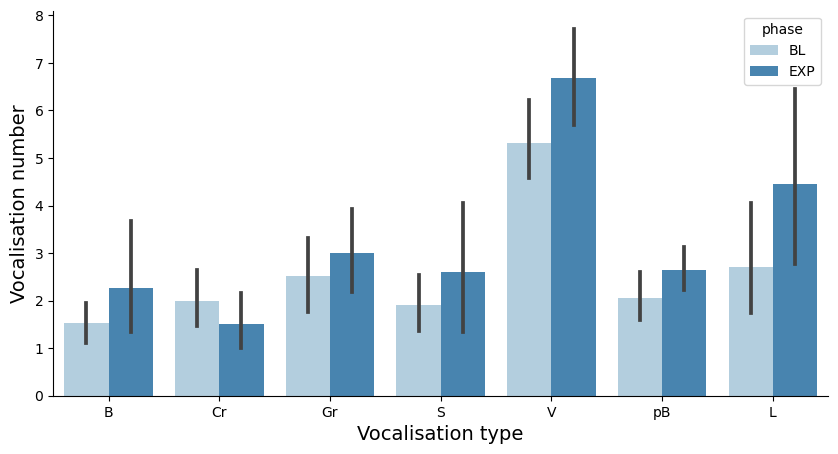

In [242]:
## FIGURE S9: Distribution of infant vocalisations by type and phase

count_vocs = df.groupby(["BB","Type_protophone","phase"])["age"].count().reset_index(name="count")
count_vocs = count_vocs[~count_vocs["Type_protophone"].isin(["UnS", "nan"])]

plt.figure(figsize=[10,5])
sns.barplot(x="Type_protophone", y="count", data = count_vocs, hue = "phase", palette = "Blues")
plt.ylabel("Vocalisation number", fontsize = 14)
plt.xlabel("Vocalisation type", fontsize = 14)
sns.despine()

# Enregistrer le graphique dans un fichier
filename = f"FIG_S9_plot_number_of_vocs_per_sounds_type.png"
filepath = os.path.join(output_dir, filename)
plt.savefig(filepath, dpi = 300)

filename_pdf = f"FIG_S9_plot_number_of_vocs_per_sounds_type.pdf"
filepath_pdf = os.path.join(output_dir, filename_pdf)
plt.savefig(filepath_pdf)

## STATS
for u in np.unique(count_vocs["Type_protophone"]):
    BLu = count_vocs.loc[((count_vocs["Type_protophone"] == u) & (count_vocs["phase"] == "BL"))]
    EXPu = count_vocs.loc[((count_vocs["Type_protophone"] == u) & (count_vocs["phase"] == "EXP"))]
    print(len(EXPu), len(BLu), u, stats.ttest_ind(BLu["count"], EXPu["count"]))

In [243]:
# ANOVA INTERACTION CONDITION/phase: does the number of vocs per type differ across phases
model = ols('count ~ phase + Type_protophone + phase:Type_protophone', data=count_vocs).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                            sum_sq     df          F        PR(>F)
phase                    81.501098    1.0   9.212172  2.558088e-03
Type_protophone        1252.185642    6.0  23.589353  5.942713e-24
phase:Type_protophone    37.064538    6.0   0.698242  6.511883e-01
Residual               3609.621003  408.0        NaN           NaN


### grand average

In [245]:
if excl_neutral:
    BIG = exp.loc[exp["cond"] != "neutre"]
    print("we keep only exp cond")
else:
    BIG = exp
    print("we keep all of the data") # ANALYSES ARE RUN WITH THIS CONDITION

## AVERAGE    
BIG_m = BIG.groupby(["BB", "cond", "age"])[["zf0_Original", "zf0_Original_inv", "f0m_NM","M_minus_NM","zf0_Original_abs", 
                                            "total_nb_voc", "bl_nb_voc", "exp_nb_voc", "nb_protophones", 
                                            "p_babbling", "p_margbabbling", "zHNR_Original", "zRMS_Original"]].mean().reset_index()
print("len b4", len(exp), "len after exclusion",len(BIG))
print(np.unique(BIG_m["BB"]))

we keep all of the data
len b4 866 len after exclusion 866
[  1  12  15  18  21  23  24  27  31  36  38  45  47  52  56  58  61  66
  68  69  70  71  72  74  77  78  81  88  90  91  92  94  96  99 100 101
 103 104 109 110 111 112 114 115 116 117 118 119 120 121 122 123 125 127
 129 130 131 133 134 141 142 143 144 148 149 150 155 156 159 160 161 163]


## MAIN ANALYSIS

In [247]:
pp = dfc_exp

In [248]:
# FIGURE 3B: F0 COMPENSATION BY CONDITION 

if excl_neutral == 1:
    ax = axes[1]
    plt.sca(ax)   # make this subplot "active"
    sns.barplot(
        x="cond",
        y="zf0c_Original",
        data=pp,
        palette=condColor,
        units="BB",
        errorbar=("ci", 95),
        estimator="mean",
        ax=ax
    )
    sns.despine(ax=ax)

    ax.set_ylabel("f0 compared to baseline (z)")
    ax.set_xlabel("condition")

    order = ["p100", "m100"]
    ax.set_xticklabels(["upward", "downward"])
    ax.set_xticks([0, 1])

    # Between-condition stats
    add_stat_annotation(
        ax, data=pp, x="cond", y="zf0c_Original", order=order,
        #box_pairs=[("p100","m100"), ("p100","neutre"), ("m100","neutre")],  #if neutral IN
        box_pairs=[("p100", "m100")], 
        test="t-test_ind",
        text_format="star",
        loc="outside",
        line_height=0.02,
        line_offset=0.03,
        verbose=2
    )
    # Helper: p-value to stars
    def p_to_star(p):
        if p < 0.001:
            return "***"
        if p < 0.01:
            return "**"
        if p < 0.05:
            return "*"
        return "ns"
    # One-sample stars vs 0
    plt.draw()

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 0.15 * (ymax - ymin), ymax)

    yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
    pad = 0.02 * yrange

    for i, cond in enumerate(order):

        vals = pp.loc[pp["cond"] == cond, "zf0c_Original"].dropna()
        tstat, pval = stats.ttest_1samp(vals, 0)

        star = p_to_star(pval)

        bar = ax.patches[i]
        mean_y = bar.get_height()

        ci_top, ci_bottom = mean_y, mean_y

        if len(ax.lines) > i:
            ydata = ax.lines[i].get_ydata()
            ci_top = float(max(ydata))
            ci_bottom = float(min(ydata))

        if mean_y >= 0:
            y = ci_top + pad
            va = "bottom"
        else:
            y = ci_bottom - pad
            va = "top"
            
        ax.text(i, y, star, ha="center", va=va, fontsize=12)

    # Panel label (only if neutral OUT, comment if neutral IN)
    ax.text(-0.25, 1.05, "B", transform=ax.transAxes,
            fontsize=14, fontweight="bold")
    
if excl_neutral == 0:
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.barplot(
        x="cond",
        y="zf0c_Original",
        data=pp,
        palette=condColor,
        units="BB",
        errorbar=("ci", 95),
        estimator="mean",
        ax=ax
    )
    sns.despine(ax=ax)

    ax.set_ylabel("f0 compared to baseline (z)")
    ax.set_xlabel("condition")

    order = ["p100", "m100", "neutre"]
    ax.set_xticklabels(["upward", "downward", "neutral"])
    ax.set_xticks([0, 1, 2])

    # Between-condition stats
    add_stat_annotation(
        ax, data=pp, x="cond", y="zf0c_Original", order=order,
        box_pairs=[("p100","m100"), ("p100","neutre"), ("m100","neutre")],  #if neutral IN
        test="t-test_ind",
        text_format="star",
        loc="outside",
        line_height=0.02,
        line_offset=0.03,
        verbose=2
    )
    # Helper: p-value to stars
    def p_to_star(p):
        if p < 0.001:
            return "***"
        if p < 0.01:
            return "**"
        if p < 0.05:
            return "*"
        return "ns"
    # One-sample stars vs 0
    plt.draw()

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 0.15 * (ymax - ymin), ymax)

    yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
    pad = 0.02 * yrange

    for i, cond in enumerate(order):

        vals = pp.loc[pp["cond"] == cond, "zf0c_Original"].dropna()
        tstat, pval = stats.ttest_1samp(vals, 0)

        star = p_to_star(pval)

        bar = ax.patches[i]
        mean_y = bar.get_height()

        ci_top, ci_bottom = mean_y, mean_y

        if len(ax.lines) > i:
            ydata = ax.lines[i].get_ydata()
            ci_top = float(max(ydata))
            ci_bottom = float(min(ydata))

        if mean_y >= 0:
            y = ci_top + pad
            va = "bottom"
        else:
            y = ci_bottom - pad
            va = "top"
        ax.text(i, y, star, ha="center", va=va, fontsize=12)
    plt.savefig(output_dir + "FIGS8A_f0c_condsep_withNeutral.png", dpi=300, bbox_inches="tight", pad_inches=0.1)

    plt.savefig(output_dir + "FIGS8A_f0c_condsep_withNeutral.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)    

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

p100 v.s. m100: t-test independent samples with Bonferroni correction, P_val=1.559e-03 stat=-3.733e+00
m100 v.s. neutre: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-9.119e-02
p100 v.s. neutre: t-test independent samples with Bonferroni correction, P_val=2.832e-02 stat=-2.712e+00


In [249]:
## STATS: + DESCRIPTIVE STATS PER EACH OF THE THREE CONDITIONS (Supplementary analysis 7 and Main Analysis)
pp100 = pp.loc[pp["cond"] == "p100"]
mm100 = pp.loc[pp["cond"] == "m100"]
nn = pp.loc[pp["cond"] == "neutre"]
print(stats.ttest_ind(pp100["zf0c_Original"], mm100["zf0c_Original"]), "\n",
      "N p100?", len(pp100), "N m100?", len(mm100),
      "- d = ", cohend(pp100["zf0c_Original"], mm100["zf0c_Original"])) 
print("+100 cent", np.mean(pp100["zf0c_Original"]), 
      np.std(pp100["zf0c_Original"]), 
      stats.ttest_1samp(pp100["zf0c_Original"], 0, nan_policy = "omit"), cohen_d_simple(pp100["zf0c_Original"], 0))
print("-100 cent", np.mean(mm100["zf0c_Original"]), 
      np.std(mm100["zf0c_Original"]),
      stats.ttest_1samp(mm100["zf0c_Original"], 0, nan_policy = "omit"), cohen_d_simple(mm100["zf0c_Original"], 0))

# if neutral cond are in: Saves Figure S8
if excl_neutral==0:
    save_axis(ax, output_dir + "FIGS8A_f0c_condsep_withNeutral.png", dpi=300, pad_inches=0.1)
    neutre = pp.loc[pp["cond"] == "neutre"]
    print("neutre", np.mean(neutre["zf0c_Original"]), np.std(neutre["zf0c_Original"]), 
          stats.ttest_1samp(neutre["zf0c_Original"], 0, nan_policy = "omit"))
    print(stats.ttest_ind(nn["zf0c_Original"], mm100["zf0c_Original"]), "\n",
      "N neutre?", len(nn), "N m100?", len(mm100),
      "- d = ", cohend(nn["zf0c_Original"], mm100["zf0c_Original"]))
    print(stats.ttest_ind(nn["zf0c_Original"], pp100["zf0c_Original"]), "\n",
      "N neutre?", len(nn), "N p100?", len(pp100),
      "- d = ", cohend(nn["zf0c_Original"], pp100["zf0c_Original"]))

TtestResult(statistic=-3.7328446511053306, pvalue=0.0005198290375159609, df=46.0) 
 N p100? 23 N m100? 25 - d =  -1.0785160506239178
+100 cent -0.17263621088223455 0.2053674091194556 TtestResult(statistic=-3.9428632211415624, pvalue=0.000693224771145285, df=22) -0.841
-100 cent 0.1804866989777102 0.3980552790180158 TtestResult(statistic=2.2213011164948626, pvalue=0.036018338199298464, df=24) 0.453
neutre 0.19400735248572273 0.6017316613508412 TtestResult(statistic=1.5462483305544128, pvalue=0.13569460638064645, df=23)
TtestResult(statistic=0.09119253717859226, pvalue=0.9277271646295409, df=47.0) 
 N neutre? 24 N m100? 25 - d =  0.02606043818435579
TtestResult(statistic=2.7119561944304142, pvalue=0.009439306223472449, df=45.0) 
 N neutre? 24 N p100? 23 - d =  0.7913380715734848


## Vocal compensation with permuted data (Supplementary Analysis 3)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

p100 v.s. m100: t-test independent samples with Bonferroni correction, P_val=5.749e-01 stat=5.635e-01


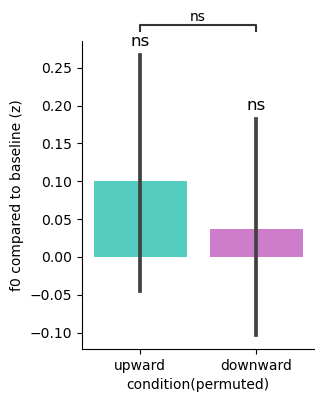

TtestResult(statistic=0.563501145710522, pvalue=0.574894438866439, df=70.0) 
 N p100? 40 N m100? 32 - d =  0.1336460313419753
+100 cent 0.10021166113358977 0.5049520317850639 TtestResult(statistic=1.2393684623529382, pvalue=0.22261569356423191, df=39) 0.198
-100 cent 0.03716389495203489 0.41000861982169967 TtestResult(statistic=0.504671852967095, pvalue=0.6173581210686813, df=31) 0.091


In [251]:
## stats for permuted data (Supplementary Analysis 3; Figure S3)
pp = dfc_exp
plt.figure(figsize=[3,4])
tini = sns.barplot(
    x="perm_cond",
    y="zf0c_Original",
    data=pp,
    palette=condColor,
    units="BB",
    estimator="mean",
    errorbar=("ci", 95)   
)

sns.despine()
tini.set_ylabel("f0 compared to baseline (z)")
tini.set_xlabel("condition(permuted)")
tini.set_xticks([0, 1])
tini.set_xticklabels(["upward", "downward"])

order = ["p100", "m100"]

# Between-condition stats
add_stat_annotation(
    tini, data=pp, x="perm_cond", y="zf0c_Original", order=order,
    box_pairs=[("p100", "m100")],
    test="t-test_ind", text_format="star", loc="outside", verbose=2
)

def p_to_star(p):
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return "ns"

# Ensure artists exist so we can read errorbars
plt.draw()

yrange = tini.get_ylim()[1] - tini.get_ylim()[0]
pad = 0.02 * yrange  # small dynamic padding

for i, cond in enumerate(order):

    vals = pp.loc[pp["perm_cond"] == cond, "zf0c_Original"].dropna()
    tstat, pval = stats.ttest_1samp(vals, 0)
    star = p_to_star(pval)

    bar = tini.patches[i]
    mean_y = bar.get_height()

    # Default fallback
    ci_top = mean_y

    if len(tini.lines) > i:
        ydata = tini.lines[i].get_ydata()
        ci_top = float(max(ydata))

    # Always above
    y = ci_top + pad
    va = "bottom"

    tini.text(i, y, star, ha="center", va=va, fontsize=12)

plt.savefig(
    output_dir + "FIGS3_f0_condsep_perm.jpg",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1
)

plt.savefig(
    output_dir + "FIGS3_f0_condsep_perm.pdf",
    bbox_inches="tight",
    pad_inches=0.1
)

plt.show()

# STATS
pp100 = pp.loc[pp["perm_cond"] == "p100"]
mm100 = pp.loc[pp["perm_cond"] == "m100"]
print(stats.ttest_ind(pp100["zf0c_Original"], mm100["zf0c_Original"]), "\n",
      "N p100?", len(pp100), "N m100?", len(mm100),
      "- d = ", cohend(pp100["zf0c_Original"], mm100["zf0c_Original"])) 
print("+100 cent", np.mean(pp100["zf0c_Original"]), 
      np.std(pp100["zf0c_Original"]), 
      stats.ttest_1samp(pp100["zf0c_Original"], 0, nan_policy = "omit"), cohen_d_simple(pp100["zf0c_Original"], 0))
print("-100 cent", np.mean(mm100["zf0c_Original"]), 
      np.std(mm100["zf0c_Original"]),
      stats.ttest_1samp(mm100["zf0c_Original"], 0, nan_policy = "omit"), cohen_d_simple(mm100["zf0c_Original"], 0))

In [252]:
#### FIGURE 3A (Main Analysis): VOCAL COMPENSATION AT THE GROUP LEVEL
axA = axes[0]
sns.violinplot(y="zf0c_Original_inv", data=pp, color="cornflowerblue", ax=axA) # Use inverted values of the upward condition response, ie, those who are hypothesised to lowed their f0

y = pp["zf0c_Original_inv"].values
rng = np.random.default_rng(0)
x = rng.normal(loc=0, scale=0.035, size=len(y))

axA.scatter(x, y, s=15, c="k", alpha=0.4, linewidths=0, zorder=3)
axA.axhline(y=0, linewidth=0.5, color="k", linestyle="--")

axA.set_ylabel("f0 compared to baseline (z)")
axA.set_xlabel("")
sns.despine(ax=axA)
axA.text(-0.25, 1.05, "A", transform=axA.transAxes, fontsize=14, fontweight="bold")

## STATS 
print("NB de bbs?", len(pp))
expected = len(pp.loc[pp["zf0c_Original_inv"] > 0])
no_change = len(pp.loc[pp["zf0c_Original_inv"] == 0])
not_expected = len(pp.loc[pp["zf0c_Original_inv"] < 0])
print("N compensate as expected?", expected, " - N no change?", no_change, " - N go in the unexpected direction?", not_expected)
print("chisq N expected vs. unexpected", stats.chisquare([expected, not_expected]))

NB de bbs? 72
N compensate as expected? 33  - N no change? 0  - N go in the unexpected direction? 15
chisq N expected vs. unexpected Power_divergenceResult(statistic=6.75, pvalue=0.0093747684594349)


## Mirror test analyses

In [254]:
#df_expected = pp.loc[pp[""]]
mir = df.groupby(["BB"])["Mirror_recognition"].mean().reset_index()
pass_mir = len(mir.loc[mir["Mirror_recognition"]==1])
fail_mir = len(mir.loc[mir["Mirror_recognition"]==0])
p_mir = (pass_mir)/((pass_mir) + (fail_mir))
p_voc = (expected)/((expected) + (no_change) + (not_expected))
print("pass_mir", (pass_mir), "fail_mir", (fail_mir), "% passing:", p_mir)
print("chisq N pass_mir vs. not", stats.chisquare([pass_mir, fail_mir]))
print("pass_voc", (expected), "fail_voc", no_change + not_expected, "% passing:", p_voc)
print("chisq N expected vs. unexpected", stats.chisquare([expected, not_expected]))
print("chisq N pass_voc (expected) vs. pass_mir", stats.chisquare([expected, pass_mir]))

## STATS ON THE NB OF BBs per condition
for u in condOrder:
    data = BIG_m.loc[BIG_m["cond"]==u]
    print("NB de bbs?", len(data), u)
    expected = len(data.loc[data["zf0_Original_inv"] > 0])
    no_change = len(data.loc[data["zf0_Original_inv"] == 0])
    not_expected = len(data.loc[data["zf0_Original_inv"] < 0])
    print("N compensate as expected?", expected, " - N no change?", no_change, " - N go in the unexpected direction?", not_expected)
    print("chisq N expected vs. unexpected", stats.chisquare([expected, not_expected]))

### IMPORTANT: For mirror Looking time analysis, see analyses_MT_gaze script ###

pass_mir 0 fail_mir 57 % passing: 0.0
chisq N pass_mir vs. not Power_divergenceResult(statistic=57.0, pvalue=4.3581190270320824e-14)
pass_voc 33 fail_voc 15 % passing: 0.6875
chisq N expected vs. unexpected Power_divergenceResult(statistic=6.75, pvalue=0.0093747684594349)
chisq N pass_voc (expected) vs. pass_mir Power_divergenceResult(statistic=33.0, pvalue=9.215887201256233e-09)
NB de bbs? 23 p100
N compensate as expected? 16  - N no change? 0  - N go in the unexpected direction? 7
chisq N expected vs. unexpected Power_divergenceResult(statistic=3.5217391304347827, pvalue=0.060568860202657664)
NB de bbs? 25 m100
N compensate as expected? 16  - N no change? 0  - N go in the unexpected direction? 9
chisq N expected vs. unexpected Power_divergenceResult(statistic=1.96, pvalue=0.16151331846753808)
NB de bbs? 24 neutre
N compensate as expected? 0  - N no change? 0  - N go in the unexpected direction? 0
chisq N expected vs. unexpected Power_divergenceResult(statistic=nan, pvalue=nan)


C:\Users\Margherita\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


## F0 vocal compensation and pitch transformation size (Supplementary analysis 2)

SignificanceResult(statistic=-0.3420477201106181, pvalue=0.003273316549927452) 72


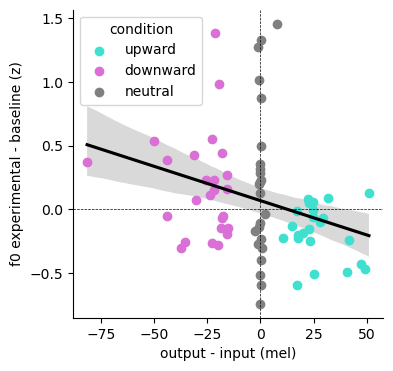

In [256]:
## FIGURE S2 & S8B : RELATIONSHIP BTW TRANSFO SIZE AND PRODUCED F0 DIFFERENCE
plt.figure(figsize=[4,4])
i = 0
sns.regplot(x="M_minus_NM", y="zf0c_Original", data = dfc_exp, order = 1, marker = " ", color = "Black", scatter=False)

handles = []
labels = []

i = 0
for u in condOrder:
    data = dfc_exp[dfc_exp["cond"] == u]
    
    h = plt.scatter(
        x=data["M_minus_NM"],
        y=data["zf0c_Original"],
        color=condColor[i]
    )
    
    handles.append(h)
    i += 1

# rename legend entries
legend_labels = ["upward", "downward", "neutral"]

plt.legend(handles, legend_labels, frameon=True, title = "condition")

# axis labels & lines
plt.ylabel("f0 experimental - baseline (z)")
plt.xlabel(difference_legend)
plt.axhline(y=0, linewidth=0.5, color='k', linestyle="--")
plt.axvline(x=0, linewidth=0.5, color='k', linestyle="--")
sns.despine()

if excl_neutral==1:
    plt.savefig(output_dir + "FIGS2_tailletransfo_concatData.png", dpi=300, format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
    plt.savefig(output_dir + "FIGS2_tailletransfo_concatData.pdf", dpi='figure', format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
    
if excl_neutral==0:
    plt.savefig(output_dir + "FIGS8b_tailletransfo_concatData_neut.png", dpi=300, format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
    plt.savefig(output_dir + "FIGS8b_tailletransfo_concatData_neut.pdf", dpi='figure', format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

print(stats.spearmanr(dfc_exp["M_minus_NM"], dfc_exp["zf0c_Original"], nan_policy="omit"), len(dfc_exp))

## Is there an effect of age? (MAIN ANALYSIS)

In [258]:
## FIGURE 3C (Main Analysis): AGE EFFECT
ax = axes[2]

sns.regplot(
    x="age",
    y="zf0c_Original_inv",
    data=pp,
    ax=ax
)

ax.set_ylabel("f0 compared to baseline (z)")
ax.set_xlabel("age in months")

ax.axhline(
    y=0,
    linewidth=0.5,
    color='k',
    linestyle="--"
)

sns.despine(ax=ax)

ax.text(-0.25, 1.05, "C", transform=ax.transAxes,
        fontsize=14,
        fontweight="bold"
)

plt.savefig(output_dir + "FIG3C_age_concat.png", dpi=300, format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.savefig(output_dir + "FIG3C_age_concat.pdf", dpi='figure', format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
# STATS
print(stats.spearmanr(pp["age"], pp["zf0c_Original_inv"], nan_policy="omit"))

SignificanceResult(statistic=-0.06096836007756371, pvalue=0.6805958739687378)


<Figure size 640x480 with 0 Axes>

In [259]:
# MERGE TOGETHER THE FIGURES OF THE PANEL (Figure 3) IN THE MAIN TEXT (Figure 3A, 3B, 3C), excluding the neutral group
if excl_neutral==1:
    fig.savefig(output_dir + "FIG3_ABC_combined.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
    fig.savefig(output_dir + "FIG3_ABC_combined.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)


## Caregiver data (Supplementary analysis 6)

In [261]:
if excl_neutral:
    exp_mum = exp_mum.loc[exp_mum["cond"] != "neutre"]
mum_m = exp_mum.groupby(["BB", "cond", "age"])[["zf0_Original", "zf0_Original_inv", "f0m_NM","M_minus_NM"]].mean().reset_index()


TtestResult(statistic=0.959746647973673, pvalue=0.34376632457475864, df=35.0) 
 N p100? 16 N m100? 21 - d =  0.31848415266219793
+100 cent 0.23755085451247057 TtestResult(statistic=0.8520094765119545, pvalue=0.4076066066097148, df=15)
-100 cent -0.2128326570149111 TtestResult(statistic=-0.608763906130507, pvalue=0.5495336156146694, df=20)


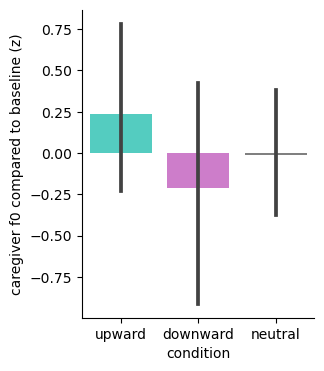

In [262]:
## FIGURE S7 and Supplementary Analysis 6: caregiver's pitch 
plt.figure(figsize=[3,4])
order = ["p100", "m100", "neutre"]
sns.barplot(x="cond", y="zf0c_Original", data = dfc_mum_exp, order = order,
             palette = condColor, units = "BB")
plt.xticks(ticks=[0, 1, 2], labels=["upward", "downward", "neutral"]) 
plt.ylabel("caregiver f0 compared to baseline (z)")
plt.xlabel("condition")
sns.despine()
handles, labels = plt.gca().get_legend_handles_labels()
plt.savefig(output_dir + "FIGS7_f0_mum.png", dpi=300, format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.savefig(output_dir + "FIGS7_f0_mum.pdf", dpi='figure', format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

## STATS
dfc_mum_exp100 = dfc_mum_exp.loc[dfc_mum_exp["cond"] == "p100"]
mm100 = dfc_mum_exp.loc[dfc_mum_exp["cond"] == "m100"]
print(stats.ttest_ind(dfc_mum_exp100["zf0c_Original"], mm100["zf0c_Original"]), "\n",
      "N p100?", len(dfc_mum_exp100), "N m100?", len(mm100),
      "- d = ", cohend(dfc_mum_exp100["zf0c_Original"], mm100["zf0c_Original"])) 
print("+100 cent", np.mean(dfc_mum_exp100["zf0c_Original"]), stats.ttest_1samp(dfc_mum_exp100["zf0c_Original"], 0, nan_policy = "omit"))
print("-100 cent", np.mean(mm100["zf0c_Original"]), stats.ttest_1samp(mm100["zf0c_Original"], 0, nan_policy = "omit"))

In [263]:
### INFANT AND MUM DATA COMBINED
mum_m["M_minus_NM_mum"] = mum_m["M_minus_NM"]
both_m = pandas.merge(BIG_m, mum_m[["BB", "cond", "M_minus_NM_mum"]], on = ["BB", "cond"])

In [264]:
### INFANT AND MUM DATA COMBINED
exp_mum["M_minus_NM_mum"] = exp_mum["M_minus_NM"]
exp_mum["zf0_Original_mum"] = exp_mum["zf0_Original"]
both = pandas.merge(BIG, exp_mum[["BB", "cond", "M_minus_NM_mum", "zf0_Original_mum"]], on = ["BB", "cond"])

dfc_mum_exp["M_minus_NM_mum"] = dfc_mum_exp["M_minus_NM"]
dfc_mum_exp["zf0c_Original_mum"] = dfc_mum_exp["zf0c_Original"]
concat_both = pandas.merge(pp, dfc_mum_exp[["BB", "cond", "M_minus_NM_mum", "zf0c_Original_mum"]], on = ["BB", "cond"])

C:\Users\Margherita\AppData\Local\Temp\ipykernel_8224\780426133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_mum["M_minus_NM_mum"] = exp_mum["M_minus_NM"]
C:\Users\Margherita\AppData\Local\Temp\ipykernel_8224\780426133.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_mum["zf0_Original_mum"] = exp_mum["zf0_Original"]


## Other voice characteristics (Suppementary analysis 5)

TtestResult(statistic=0.6014044412824567, pvalue=0.5505231284454835, df=46.0) 
 N p100? 23 N m100? 25 N neutre? 24 - d =  0.1737614081120615
+100 cent 0.028230266073865872 TtestResult(statistic=0.20765920724652495, pvalue=0.8374053313960529, df=22)
-100 cent -0.1016841499111242 TtestResult(statistic=-0.6157523903335287, pvalue=0.5438538873925083, df=24)
neutre TtestResult(statistic=-0.5880370758037984, pvalue=0.5622374754762016, df=23)
neutre vs p100 TtestResult(statistic=-0.5720098043066361, pvalue=0.5701619452211208, df=45.0)
neutre vs m100 TtestResult(statistic=0.06673447888829875, pvalue=0.947076162373238, df=47.0)
p100 vs m100 TtestResult(statistic=0.6014044412824567, pvalue=0.5505231284454835, df=46.0)


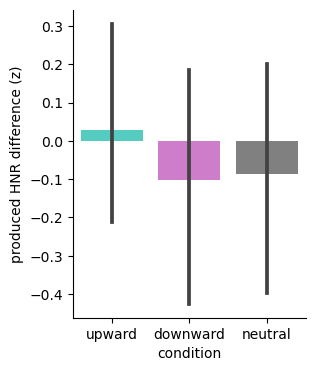

In [266]:
#### FIGURE S6 and Supplementary Analysis 5: HNR by cond
plt.figure(figsize=[3,4])
sns.barplot(x="cond", y="zHNR_Original", data= BIG_m, palette = condColor, units = "BB")
plt.xticks(ticks=[0, 1, 2], labels=["upward", "downward", "neutral"])
plt.ylabel("produced HNR difference (z)")
plt.xlabel("condition")
handles, labels = plt.gca().get_legend_handles_labels()
sns.despine()
plt.savefig(output_dir + "FIGS6_HNR_cond.png", dpi=300, format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

plt.savefig(output_dir + "FIGS6_HNR_cond.pdf", dpi='figure', format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

p100 = BIG_m.loc[BIG_m["cond"] == "p100"]
m100 = BIG_m.loc[BIG_m["cond"] == "m100"]
neutre = BIG_m.loc[BIG_m["cond"] == "neutre"]

# STATS
print(stats.ttest_ind(p100["zHNR_Original"], m100["zHNR_Original"]), "\n",
      "N p100?", len(p100), "N m100?", len(m100), "N neutre?", len(neutre),
      "- d = ", cohend(p100["zHNR_Original"], m100["zHNR_Original"])) 
print("+100 cent", np.mean(p100["zHNR_Original"]), stats.ttest_1samp(p100["zHNR_Original"], 0, nan_policy = "omit"))
print("-100 cent", np.mean(m100["zHNR_Original"]), stats.ttest_1samp(m100["zHNR_Original"], 0, nan_policy = "omit"))
print("neutre", stats.ttest_1samp(neutre["zHNR_Original"], 0, nan_policy = "omit"))
print("neutre vs p100", stats.ttest_ind(neutre["zHNR_Original"], p100["zHNR_Original"], nan_policy = "omit"))
print("neutre vs m100", stats.ttest_ind(neutre["zHNR_Original"], m100["zHNR_Original"], nan_policy = "omit"))
print("p100 vs m100", stats.ttest_ind(p100["zHNR_Original"], m100["zHNR_Original"], nan_policy = "omit"))

+100 cent 0.3921381306999394 TtestResult(statistic=1.9492604543551888, pvalue=0.06412685452677616, df=22)
-100 cent 0.5853534190490647 TtestResult(statistic=2.5869853332056905, pvalue=0.01617284914587065, df=24)
neutre 1.119406173918814 TtestResult(statistic=1.858364627098719, pvalue=0.0759629076485828, df=23)
neutre vs p100 TtestResult(statistic=1.1252687651477293, pvalue=0.26644124906577554, df=45.0)
neutre vs m100 TtestResult(statistic=0.8429457061516137, pvalue=0.4035283097659992, df=47.0)
p100 vs m100 TtestResult(statistic=-0.6338892769246951, pvalue=0.5292927235817354, df=46.0) 
 N p100? 23 N m100? 25 N neutre? 24 - d =  -0.18314712327480195


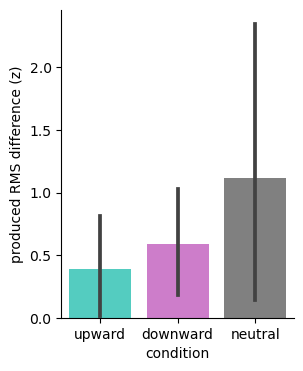

In [267]:
#### FIGURE S5 and Supplementary Analysis 5: RMS by cond
plt.figure(figsize=[3,4])
sns.barplot(x="cond", y="zRMS_Original", data= BIG_m, palette = condColor, units = "BB")
plt.xticks([]) 
plt.ylabel("produced RMS difference (z)")
plt.xlabel("condition")
plt.xticks(ticks=[0, 1, 2], labels=["upward", "downward", "neutral"])
handles, labels = plt.gca().get_legend_handles_labels()
sns.despine()
plt.savefig(output_dir + "FIGS5_RMS_cond.png", dpi=300, format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.savefig(output_dir + "FIGS5_RMS_cond.pdf", dpi='figure', format=None, metadata=None,
            bbox_inches = "tight", pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

p100 = BIG_m.loc[BIG_m["cond"] == "p100"]
m100 = BIG_m.loc[BIG_m["cond"] == "m100"]
neutre = BIG_m.loc[BIG_m["cond"] == "neutre"]

print("+100 cent", np.mean(p100["zRMS_Original"]), stats.ttest_1samp(p100["zRMS_Original"], 0, nan_policy = "omit"))
print("-100 cent", np.mean(m100["zRMS_Original"]), stats.ttest_1samp(m100["zRMS_Original"], 0, nan_policy = "omit"))
print("neutre", np.mean(neutre["zRMS_Original"]), stats.ttest_1samp(neutre["zRMS_Original"], 0, nan_policy = "omit"))
print("neutre vs p100", stats.ttest_ind(neutre["zRMS_Original"], p100["zRMS_Original"], nan_policy = "omit"))
print("neutre vs m100", stats.ttest_ind(neutre["zRMS_Original"], m100["zRMS_Original"], nan_policy = "omit"))
print("p100 vs m100", stats.ttest_ind(p100["zRMS_Original"], m100["zRMS_Original"]), "\n",
      "N p100?", len(p100), "N m100?", len(m100), "N neutre?", len(neutre),
      "- d = ", cohend(p100["zRMS_Original"], m100["zRMS_Original"]))

## Save dataframes for statistical analyses in R

In [269]:
title = "N" + str(nsuj) + "_B.csv"
#print(title)
BIG[["BB", "voc_nb_all", "cond", "age", "zf0_Original", "M_minus_NM", "Type_protophone",
     "zf0_Original_inv", "p_margbabbling", "difference_inv"]].to_csv(title, sep=";")

## AND MERGED DATA
both = both[~np.isnan(both["M_minus_NM_mum"])]
both[["BB", "cond", "age", "zf0_Original", "zf0_Original_mum", "M_minus_NM", 
      "M_minus_NM_mum"]].to_csv("N" + str(nsuj) + "_both.csv", sep=";")

concat_both = concat_both[~np.isnan(concat_both["M_minus_NM_mum"])]
concat_both[["BB", "cond", "age", "zf0c_Original", "zf0c_Original_mum", "M_minus_NM", 
      "M_minus_NM_mum"]].to_csv("N" + str(nsuj) + "_concat_both.csv", sep=";")

## TRANSFO DATA
dfc[["BB", "cond", "age", "phase", "M_minus_NM"]].to_csv("N" + str(nsuj) + "_phases.csv", sep=";")

### concat data
pp[["BB", "cond", "age", "phase", "M_minus_NM", "zf0c_Original"]].to_csv("N" + str(nsuj) + "_concat.csv", sep=";")